In [19]:
"""
@author: Yanan Xiong
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,least_squares
from scipy.stats import norm
from matplotlib.pyplot import MultipleLocator
import warnings
import datetime

#Definitions of Global variables
C0 = 8 # initial concentration of adsorbate
Cs = 40.0 # initial concentration of adsorbent
t = np.array([0,
5,
10,
15,
20,
25,
30,
35,
40])
qt = np.array([0,
0.089904,
0.11238,
0.138602,
0.161078,
0.172316,
0.179808,
0.1873,
0.1873])
dt=0.01

warnings.filterwarnings('ignore')

#### PSO takes the form:
\begin{equation}\label{eq1}
    \frac{dq_{t}}{dt} = k_{2}(q_{e} - q_{t})^{2}
\end{equation}
where $t$ is the time (minutes), $q_{t}$ is the amount of adsorbate adsorbed per mass of adsorbent at time $t$ (mg g$^{-1}$), and $q_{e}$ is the amount of adsorbate adsorbed at equilibrium (mg g$^{-1}$).

When apply the boundary conditions $t=0$ and $t=t$, $qt=0$ and $qt=qt$ and integrate eq1, we can have:
\begin{equation}\label{eq4}
    q_t = \frac{q_{e}^{2}kt}{1+q_{e}t}
\end{equation}

#### linearized PSO
The first approach towards the adsorption kinetics uses the linearized form of the integrated PSO rate equation
\begin{equation}\label{eq5}
    \frac{t}{q_{t}} = \frac{1}{k_{2}q_{e}^{2}} + \frac{t}{q_{e}}
\end{equation}
which can be regarded as a linear form of $y = mx + c$. $\frac{t}{q_{t}}$ is plotted as a function of $t$, where $m$ is the slope of the linear regression and $c$ is the y-intercept. The linear regression was implement using the built-in function $LinearRegression()$ from $sklearn$ package, which minimising the residual sum of squares between the data points and the linear regression. Hence, the equilibrium adsorption parameter $q_{e} = \frac{1}{m}$ and the $k_{2} = \frac{1}{cq_{e}^{2}}$.

#### nonlinearized PSO
Secondly, the nonlinear PSO kinetics were calculated, via an in-built function named $curve\_solve$ from the $SciPy$ package, which minimizes the sum of squared residuals between the model and experimental data, and has function has no limit to the type of curve. The initial guess applied for $curve\_solve$ is the results obtained from the linear regression.

In [7]:
### equation to get q by PSO

def PSO_getQ(t,qe,k2):
    return t/((t/qe)+(1/(k2*qe**2)))

### linear PSO

def PSO_linear(t,qt):
    # get the m and c for the linearized curve
    t_qt = t[1:]/qt[1:]
    t1=t.reshape(-1,1)
    model = LinearRegression()
    model.fit(t1[1:],t_qt)
    c = float(model.intercept_)
    m = float(model.coef_)
    # calculate the parameters (qe and k2) from the c,m
    qe = 1/m
    k2 = 1/(c*qe*qe)
    
    # calculate the r^2 value
    q_model = PSO_getQ(t, qe, k2)
    r_sq = 1 - ((qt-q_model)**2).sum()/((qt-qt.mean())**2).sum()
    
    return qe,k2,r_sq
### nonlinear PSO

def PSO_nonlinear(t,qt):
    # use the qe,k2 from linear method as initial guess
    p1,p2,_ = PSO_linear(t,qt)
    p0 = np.array([p1,p2])
    # find the optimised parameters qe,k2 fitting the PSO equation,
    # by using the given t,qt
    popt,pcov = curve_fit(PSO_getQ, t, qt, p0=p0)
    qe,k2 = popt
    
    # calculate the r^2 value 
    q_model = PSO_getQ(t,qe,k2)
    r_sq = 1 - ((qt-q_model)**2).sum()/((qt-qt.mean())**2).sum()
    
    return qe,k2,r_sq

### revised PSO
#### The concentration of aqueous adsorbate left at time $t$ is 
\begin{equation}\label{eq2}
    C_{t} = C_{0} - C_{s}q_{t}
\end{equation}
where $C_{t}$ is the concentration of the aqueous adsorbate at time $t$ (mg L$^{-1}$), $C_{0}$ is the initial adsorbate concentration at $t$ = 0 (mg L$^{-1}$), and {$C_{s}$} is the concentration of the adsorbent (g L$^{-1}$).

#### revised PSO takes the form: 
\begin{equation}\label{eq3}
    \frac{dq_{t}}{dt} = k'C_{t} (1 - \frac{q_{t}}{q_{e}})^{2}
\end{equation}
where the unit of rate constant $k'$ is L g$^{-1}$min$^{-1}$.
For including the operation conditions $C_{0}$ and $C_{t}$ in the equation, the $k'$ here substitutes the $\frac{k_{2}q_{e}^{2}}{C_{0}^{2}}$, combining the eq1 and eq2 together. 

Thirdly, the kinetics were obtained from the revised rate equation eq3. Due to the difficulty of integration of the rPSO, Bullen expressed the adsorbed adsorbate at the $n$th data point as 
\begin{equation}\label{eq6}
    q_{n} = q_{n-1} + ((t_{n} - t_{n-1})(k'C_{t(n-1)}(1-\frac{q{n-1}}{q_{e}})^{2}))
\end{equation}
The rPSO parameters $k'$ and $q_{e}$ were obtained by fitting the model to the experimental data via $curve_solve$ to minimize the sum of squared residuals. Both results from the linear and nonlinear PSO were used as the initial guess. They show the same results for the used set of experimental data.


In [8]:
### equation to get q by revised PSO

def rPSO_getQ(t,qe,kprime):
    # create time series with dt timestep
    t1 = np.arange(0,t[-1]+dt,dt)
    t_index = np.array(t*(1/dt),'i')
    # calculate qt for each timestep
    q = np.zeros(len(t1),dtype="float")
    q_model = []
    for i in range(1,len(t1)):
        q[i] = q[i-1]+(dt*(kprime*(C0-Cs*q[i-1])*(1-q[i-1]/qe)**2))
    # extract data points corresponding to the experimental data
    for j in t_index:
        q_model.append(q[j])
    return q_model

def rPSO_nonlinear(t,qt):           

    p1,p2,_ = PSO_nonlinear(t,qt)
    p1 = float(p1)
    p2 = float(p2*p1**2/C0**2)
    p0 = np.array([p1,p2])
    
    # find the optimised parameters qe,k2 fitting the PSO equation,
    # by using the given t,qt
    popt,pcov = curve_fit(rPSO_getQ, t, qt, p0=p0,bounds=([0.00000001,0],np.inf))
    qe,kprime = popt
    
    # calculate the r^2 value 
    q_model = rPSO_getQ(t,qe,kprime)
    r_sq = 1 - ((qt-q_model)**2).sum()/((qt-qt.mean())**2).sum()
    return qe,kprime,r_sq


In [9]:
def MonteCarlo(q_model,qe,k,func):
    # create the array to store the parameters obtained by the two MonteCarlo simulations
    k_MC = np.zeros(200)
    qe_MC = np.zeros(200)
    
    size = np.size(t)
    SSE = np.sum(np.square(q_model-qt))
    std = np.sqrt(SSE/(size-2))
    q_monte = np.zeros(size)
    
    # repeat the Monte Carlo simulation for 200 times 
    for i in range(200):
        q_monte = q_model + norm.ppf(np.random.rand(size), 0, std)
        # put the simulated data into models to obtain the parameters
        qe_MC[i],k_MC[i],_ = func(t,q_monte)
        
    # qe and k in confidence level of 95%
    qe_MC = sorted(qe_MC)
    k_MC = sorted(k_MC)
    qe_CL = qe_MC[5:195]
    k_CL = k_MC[5:195]

    # uncertainties
    qe_un = (qe_CL[-1]-qe_CL[0])/2
    k_un = (k_CL[-1]-k_CL[0])/2
    
    return qe_un,k_un

### Results

In [18]:
print("manna: linearised PSO")
qe,k2,r_sq= PSO_linear(t,qt)
q_model= t/((t/qe)+(1/(k2*qe**2)))
m = 1/qe
c = 1/k2/qe/qe
y = t[1:]/qt[1:]
y_model=m*t+c
r =  1 - ((y-y_model[1:])**2).sum()/((y-y.mean())**2).sum()
qe_un,k2_un = MonteCarlo(q_model,qe,k2,PSO_linear)
print(f"qe: {'%.6f'%qe} +- {'%.6f'%qe_un}")
print(f"k2: {'%.6f'%k2} +- {'%.6f'%k2_un}")
print(f"R^2: {'%.6f'%r_sq}")
print(f"qt_model: {q_model}")

manna: linearised PSO
qe: 0.234399 +- 0.015770
k2: 0.453010 +- 0.129849
R^2: 0.993581
qt_model: [0.         0.08128967 0.12071524 0.14399437 0.15936015 0.1702614
 0.17839707 0.18470111 0.18972947]


In [16]:
print("manna: non linearised PSO")
qe,k2,r_sq = PSO_nonlinear(t,qt)
q_model= t/((t/qe)+(1/(k2*qe**2)))
qe_un,k2_un = MonteCarlo(q_model,qe,k2,PSO_nonlinear)
print(f"qe: {'%.6f'%qe} +- {'%.6f'%qe_un}")
print(f"k2: {'%.6f'%k2} +- {'%.6f'%k2_un}")
print(f"R^2: {'%.6f'%r_sq}")
print(f"qt_model: {q_model}")

manna: non linearised PSO
qe: 0.234748 +- 0.014654
k2: 0.448541 +- 0.114986
R^2: 0.993592
qt_model: [0.         0.08096298 0.12040058 0.14373938 0.15916598 0.17012074
 0.17830195 0.18464457 0.18970579]


In [21]:
starttime = datetime.datetime.now()
print('manna: nonlinear rPSO')
qe,kprime,r_sq= rPSO_nonlinear(t,qt)
q_model= rPSO_getQ(t,qe,kprime)
qe_un,kprime_un = MonteCarlo(q_model,qe,kprime,rPSO_nonlinear)
print(f"qe: {'%.6f'%qe} +- {'%.6f'%qe_un}")
print(f"k2: {'%.6f'%kprime} +- {'%.6f'%kprime_un}")
print(f"R^2: {'%.6f'%r_sq}")
print(f"qt_model: {q_model}")
endtime = datetime.datetime.now()
print("time consuming:",endtime - starttime)

manna: nonlinear rPSO
qe: 0.562841 +- 0.407637
k2: 0.003056 +- 0.000712
R^2: 0.992953
qt_model: [0.0, 0.08074487874280899, 0.12077829856069035, 0.14449738887597188, 0.15988669832690613, 0.17042537391735638, 0.17789866951395747, 0.18332576108240492, 0.18733360169560734]
time consuming 0:00:31.053795


### Visualized as plots

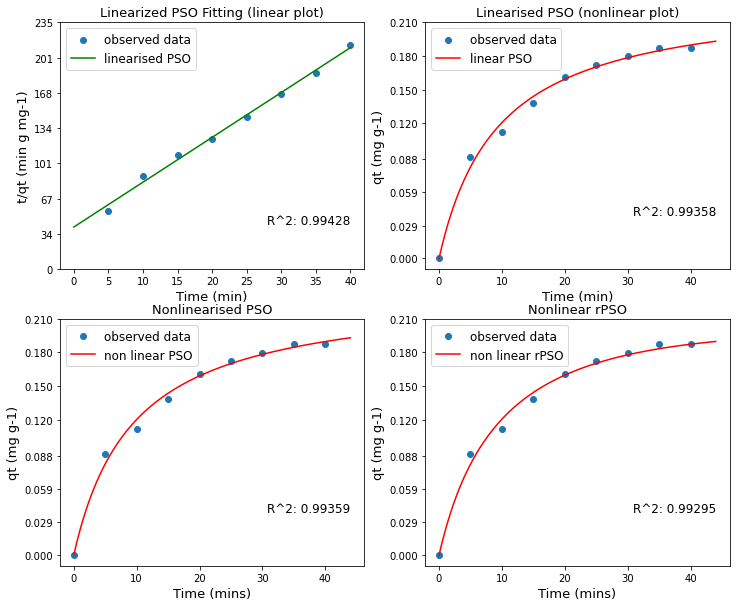

In [20]:
plt.figure(figsize = (12,10),label="Manna PSO")
plt.figure(1)
ax1 = plt.subplot(221)
plt.title('Linearized PSO Fitting (linear plot)',fontsize=13)
qe,k2,r_sq= PSO_linear(t,qt)
q_model= t/((t/qe)+(1/(k2*qe**2)))
m = 1/qe
c = 1/k2/qe/qe
y = t[1:]/qt[1:]
y_model=m*t+c
r2 =  1 - ((y-y_model[1:])**2).sum()/((y-y.mean())**2).sum()
plt.scatter(t,t/qt,label = "observed data")
plt.plot(t,y_model,"green",label = "linearised PSO")
ax1.legend(loc='upper left')
ax1.legend("R^2: {r}")
ax1.legend(fontsize=12)
ax1.set_xlabel('Time (min)',fontsize=13)
ax1.set_ylabel('t/qt (min g mg-1)',fontsize=13)
ax1.text(0.7*t.max(),0.2*y.max(),f"R^2: {'%.5f'%r2}",fontsize=12)
new_ticks = np.linspace(0, 1.1*y.max(), 8)
plt.yticks(new_ticks)
for i in range(np.size(new_ticks)):
    if new_ticks[i] < 100:
        new_ticks[i] = format(new_ticks[i],'.2g')
    elif new_ticks[i] >= 100:
        new_ticks[i] = format(new_ticks[i],'.3g')
plt.yticks(new_ticks,fontsize=10)
plt.xticks(fontsize=10)

ax2 = plt.subplot(222)
plt.title('Linearised PSO (nonlinear plot)',fontsize=13)
plt.scatter(t,qt,label = "observed data")
t_p = np.linspace(0, 1.1*t.max(), 100)
q_model= t_p/((t_p/qe)+(1/(k2*qe**2)))
ax2.plot(t_p,q_model,"red",label = "linear PSO")
ax2.legend(loc='upper left')
ax2.legend("R^2: {r_sq}")
ax2.legend(fontsize=12)
ax2.set_xlabel('Time (min)',fontsize=13)
ax2.set_ylabel('qt (mg g-1)',fontsize=13)
ax2.text(0.7*t_p.max(),0.2*q_model.max(),f"R^2: {'%.5f'%r_sq}",fontsize=12)
new_ticks = np.linspace(0, 1.1*qt.max(), 8)
for i in range(np.size(new_ticks)):
    if new_ticks[i] < 100:
        new_ticks[i] = format(new_ticks[i],'.2g')
    elif new_ticks[i] >= 100:
        new_ticks[i] = format(new_ticks[i],'.3g')
plt.yticks(new_ticks,fontsize=10)
plt.xticks(fontsize=10)



ax3 = plt.subplot(223)
plt.title('Nonlinearised PSO',fontsize=13)
plt.scatter(t,qt,label = "observed data")
qe,k2,r_sq= PSO_nonlinear(t,qt)
q_model= t_p/((t_p/qe)+(1/(k2*qe**2)))
plt.plot(t_p,q_model,'red', label ="non linear PSO")
ax3.legend(loc='upper left')
ax3.legend(fontsize=12)
ax3.set_xlabel('Time (mins)',fontsize=13)
ax3.set_ylabel('qt (mg g-1)',fontsize=13)
ax3.text(0.7*t_p.max(),0.2*q_model.max(),f"R^2: {'%.5f'%r_sq}",fontsize=12)
new_ticks = np.linspace(0, 1.1*qt.max(), 8)
for i in range(np.size(new_ticks)):
    if new_ticks[i] < 100:
        new_ticks[i] = format(new_ticks[i],'.2g')
    elif new_ticks[i] >= 100:
        new_ticks[i] = format(new_ticks[i],'.3g')
plt.yticks(new_ticks,fontsize=10)
plt.xticks(fontsize=10)




ax4 = plt.subplot(224)
plt.title('Nonlinear rPSO',fontsize=13)
plt.scatter(t,qt,label = "observed data")
qe,kprime,r_sq= rPSO_nonlinear(t,qt)
q_model= rPSO_getQ(t_p,qe,kprime)
plt.plot(t_p,q_model,"red",label ="non linear rPSO")
ax4.legend(loc='upper left')
ax4.legend("R^2: {r_sq}")
ax4.legend(fontsize=12)
ax4.set_xlabel('Time (mins)',fontsize=13)
ax4.set_ylabel('qt (mg g-1)',fontsize=13)
ax4.text(0.7*t_p.max(),0.2*q_model[-1],f"R^2: {'%.5f'%r_sq}",fontsize=12)
new_ticks = np.linspace(0, 1.1*qt.max(), 8)
for i in range(np.size(new_ticks)):
    if new_ticks[i] < 100:
        new_ticks[i] = format(new_ticks[i],'.2g')
    elif new_ticks[i] >= 100:
        new_ticks[i] = format(new_ticks[i],'.3g')
plt.yticks(new_ticks,fontsize=10)
plt.xticks(fontsize=10)
plt.show()